# Multivariate Normal Likelihood with Multivariate Normal Prior

This is a simple model where our data, $y$, is modelled as a multivariate normal RV with uncorrelated noise.

$L(x) = p(y | x) = \mathcal{N}[y \mid x,\Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu, \sigma^2 \mathbf{I}]$.

The analytic evidence for this model is,

$Z = p(y) = = \mathcal{N}[y \mid \mu, \Sigma + \sigma^2 \mathbf{I}]$

The posterior is also a multivariate normal distribution,

$p(x \mid y) = \mathcal{N}[\mu', \Sigma']$

where

$\mu' = \sigma^2 \mathbf{I} (\sigma^2 \mathbf{I} + \Sigma)^{-1} y + \Sigma (
    \sigma^2 \mathbf{I} + \Sigma)^{-1}  \mu$

and

$\Sigma' = \sigma^2 \mathbf{I}  (\sigma^2 \mathbf{I}  + \Sigma)^{-1} \Sigma$

## Overview

We'll cover the following topics:

1. How to define your prior with a `PriorChain` context.
2. How to define your likelihood
3. How to compute Bayesian evidence of your model with standard nested sampling (without much tuning of parameters).
4. How to inspect and plot your results.
5. How to save and load your results.
6. How to time your execution.
7. How to marginalise over the posterior.

In [1]:

from jaxns import NestedSampler, save_results
from jaxns.prior_transforms import PriorChain, MVNPrior
from jaxns import summary, marginalise_dynamic
from jaxns import plot_cornerplot, plot_diagnostics
from jax.scipy.linalg import solve_triangular
from jax import random, jit
from jax import numpy as jnp
from timeit import default_timer

In [2]:
def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    return -0.5 * x.size * jnp.log(2. * jnp.pi) - jnp.sum(jnp.log(jnp.diag(L))) \
           - 0.5 * dx @ dx

# define our data and prior
ndims = 3
prior_mu = 2 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2

data_mu = jnp.zeros(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.99, data_cov)

true_logZ = log_normal(data_mu, prior_mu, prior_cov + data_cov)

J = jnp.linalg.solve(data_cov + prior_cov, prior_cov)
post_mu = prior_mu + J.T @ (data_mu - prior_mu)
post_cov = prior_cov - J.T @ (prior_cov + data_cov) @ J

print("True logZ={}".format(true_logZ))
print("True post_mu={}".format(post_mu))
print("True post_cov={}".format(post_cov))


WARNING[2022-04-06 17:42:57,687]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


True logZ=-4.964944362640381
True post_mu=[1.4974875 1.4974873 1.4974874]
True post_cov=[[0.25618196 0.24628097 0.24628088]
 [0.24628095 0.25618184 0.24628094]
 [0.24628088 0.24628098 0.2561819 ]]


In [3]:
# A PriorChain holds the definition of your prior. A number of priors are provided, and really complex ones are easy to implement.

# Simple use a PriorChain context like so to define your prior RVs.
with PriorChain() as prior_chain:
    MVNPrior('x', prior_mu, prior_cov)

# We can print the prior model like so. This will should the generative structure of the model, the dtypes, and shapes of RVs.
# In this case, it's a simple MVNPrior as defined above.
print(prior_chain)

# Note: you'll see _x_Sigma and _x_mu RVs. These are singular RVs (as shown by their DeltaPrior distributions). In JAXNS every parameter of a model can be a RV, which allows us to define complex hierarchical models.

_x_Sigma ~ float32(3, 3) : DeltaPrior(array<(3, 3)>)
_x_mu ~ float32(3,) : DeltaPrior(array<(3,)>)
x ~ float32(3,) : MVNPrior(_x_mu,_x_Sigma)


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


In [4]:
# The likelihood is a callable that will take
def log_likelihood(x):
    return log_normal(x, data_mu, data_cov)



In [5]:
# Create the nested sampler class. In this case without any tuning.
# gradient_boost=True will assist in situations with strongly correlated posteriors
ns = NestedSampler(log_likelihood, prior_chain,
                   dynamic=True)
# jit compile
ns = jit(ns)
results = ns(random.PRNGKey(4525325),G=0.,
             termination_evidence_uncert=0.05,adaptive_evidence_stopping_threshold=0.01,
             adaptive_evidence_patience=1)


WARNING[2022-04-06 17:42:58,218]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/j

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


In [6]:
# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Evidence uncertainty low enough
--------
# likelihood evals: 3046083
# samples: 14100
# likelihood evals / sample: 216.0
--------
logZ=-4.915 +- 0.054
H=0.75
ESS=3640
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 1.41 +- 0.54 | 0.72 / 1.41 / 2.11 | 1.47 | 0.05
x[1]: 1.41 +- 0.54 | 0.72 / 1.4 / 2.12 | 1.58 | 0.05
x[2]: 1.41 +- 0.54 | 0.72 / 1.41 / 2.1 | 1.66 | 0.05
--------


'--------\nTermination Conditions:\nEvidence uncertainty low enough\n--------\n# likelihood evals: 3046083\n# samples: 14100\n# likelihood evals / sample: 216.0\n--------\nlogZ=-4.915 +- 0.054\nH=0.75\nESS=3640\n--------\nx[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nx[0]: 1.41 +- 0.54 | 0.72 / 1.41 / 2.11 | 1.47 | 0.05\nx[1]: 1.41 +- 0.54 | 0.72 / 1.4 / 2.12 | 1.58 | 0.05\nx[2]: 1.41 +- 0.54 | 0.72 / 1.41 / 2.1 | 1.66 | 0.05\n--------'

WARNING[2022-04-06 17:43:25,195]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:43:25,422]: No handles with labels found to put in legend.


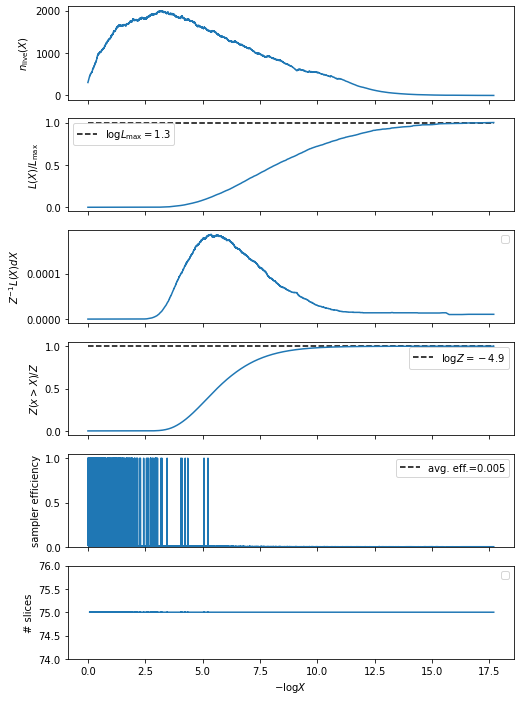

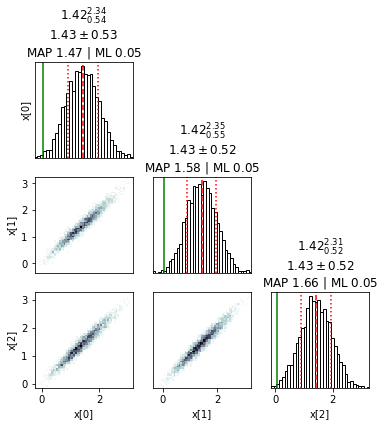

In [7]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)

In [8]:

# We can always save results to play with later
save_results(results, 'save.npz')
# loads previous results by uncommenting below
# results = load_results('save.npz')


In [9]:
# Since our `ns` callable is already jit-compiled we can measure its performance.

# now we time the run.
t0 = default_timer()
# run again and time it. You can change the key, and run a few times to get a statistic estimate too.
results = ns(random.PRNGKey(4525325),G=0.,
             termination_evidence_uncert=0.05,adaptive_evidence_stopping_threshold=0.01,
             adaptive_evidence_patience=1)
# Here we block unti completion on any array in result.
results.log_efficiency.block_until_ready()
run_time = default_timer() - t0

print(f"Total run time: {run_time} s")

Total run time: 5.982364399009384 s


In [10]:
# Let us now consider how to marginalise over the posterior.

def param_mean(x):
    return x



post_mean = marginalise_dynamic(random.PRNGKey(42),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    ESS=results.ESS,
                    fun=param_mean)

def param_covariance(x):
    dx = x - post_mean
    return jnp.outer(dx, dx)

post_covariance = marginalise_dynamic(random.PRNGKey(42),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    ESS=results.ESS,
                    fun=param_covariance)

print(f"Estimated posterior mean:\n{post_mean}")
print(f"True posterior mean:\n{post_mu}")

print(f"Estimated posterior covariance:\n{post_covariance}")
print(f"True posterior covariance:\n{post_cov}")

Estimated posterior mean:
[1.4498533 1.4463645 1.4483762]
True posterior mean:
[1.4974875 1.4974873 1.4974874]
Estimated posterior covariance:
[[0.27146706 0.2598412  0.25923693]
 [0.2598412  0.26744413 0.2572612 ]
 [0.25923693 0.2572612  0.26614636]]
True posterior covariance:
[[0.25618196 0.24628097 0.24628088]
 [0.24628095 0.25618184 0.24628094]
 [0.24628088 0.24628098 0.2561819 ]]
